# Computer vision learnings

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import time

import matplotlib.pyplot as plt

import math
import json

#import ML liberaries
import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split

In [2]:
# Get the data from CSV file
data = pd.read_csv('collected_training_data.csv')

## 1. Visually Explore training data

In [3]:
# A function that takes the index and produce the image in that index in dataframe

def review_data (row):
    # get the image by location (as json format)
    img_as_json = data['images'][row]

    # convert the json to nested list
    img_as_list = json.loads(img_as_json)

    # convert the nested list to np.array
    img = np.array(img_as_list)

    # show the image
    plt.imshow(img, cmap='gray')
    plt.title(data['motion'][row])
    plt.show()


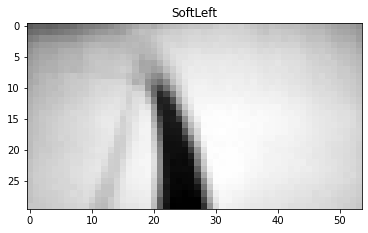

In [4]:
review_data (1900)

In [5]:
    
def preview_dataset(data = data, START_FRAME = 200, END_FRAME = 300 ):
    no_of_frames = END_FRAME - START_FRAME
    # number of histograms per raws & columns
    # import math
    nrows = math.ceil(no_of_frames/5)
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows * 2.5))

    # Flattening the axs array to iterate through it
    axs = axs.flatten()

    # iterate through data to create histograms
    for i, j in zip(range(START_FRAME,END_FRAME ), range(no_of_frames)):
        # get the image by location (as json format)
        img_as_json = data['images'][i]

        # convert the json to nested list
        img_as_list = json.loads(img_as_json)

        # convert the nested list to np.array
        img = np.array(img_as_list)
        axs[j].imshow(img, cmap='gray')
        axs[j].set_title(f"{data['motion'][i]} , {data['LMR'][i]} ") # ,  {data['time-sec'][i]}

        # Hiding empty subplots if any
        for k in range(no_of_frames, len(axs)):
            axs[k].axis('off')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

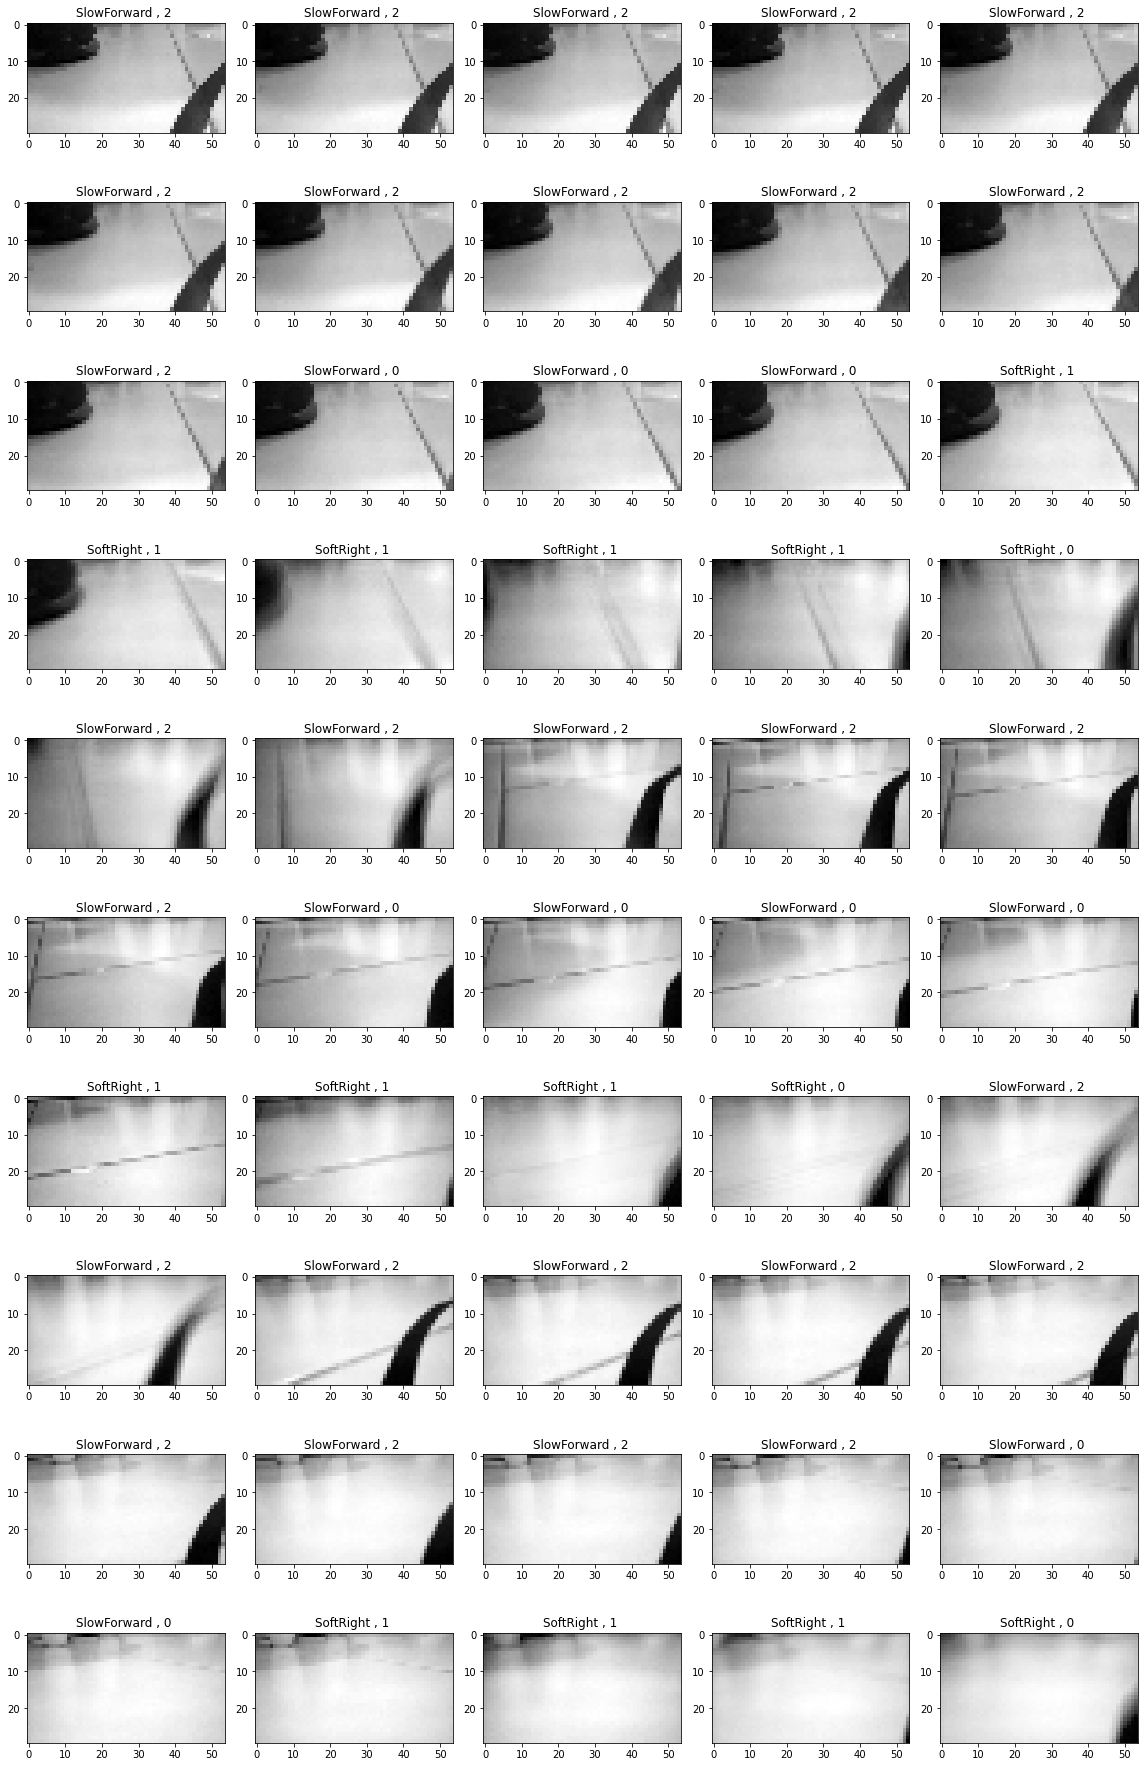

In [6]:
preview_dataset(data = data, 
                START_FRAME = 0, 
                END_FRAME = 50 )

## 2. Prepare Data for Model Training

In [7]:
# Get the motion encoding from external CSV file
lookup = pd.read_csv('lookup.csv')
lookup.index = lookup['motion_encoding']
data = data.merge(lookup)

In [8]:
data.head(1)

,motion,timestamp,i,LMR,run_name,img_name,time-sec,images,motion_encoding
0,SlowForward,2023-12-29 22:32:20.819473,0,2,clockwise,0-2023-12-29 22_32_20.819473.jpg,NaN,"[[7, 9, 11, 8, 12, 12, 11, 13, 15, 17, 18, 20,...",0


In [9]:
# organise data in the right format for model training
X = []
Y = []

for i in range(len(data)):
    # get the image by location (as json format)
    img_as_json = data['images'][i]
    # convert the json to nested list
    img_as_list = json.loads(img_as_json)
    motion = data['motion_encoding'][i]
    X.append(img_as_list)
    Y.append(motion)

In [10]:
# Convert the nested lists to np.array lists (the format required by Tensorflow to train model)
X = np.array(X)
Y = np.array(Y)

In [11]:
# Run a few checks to confirm data type and structure
type(X), X.dtype, X.shape

(numpy.ndarray, dtype('int32'), (1923, 30, 54))

In [12]:
# Split data for training & testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 3. Train & Evaluate ML model

inspiration: source: https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb

In [13]:
# scale data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [14]:
# initiate model
model = Sequential()

# build model
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(30,54,1))) # (hight, width, color)
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu')) 
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile model
model.compile('adam', loss=SparseCategoricalCrossentropy(from_logits=True) , metrics=['accuracy'])  #  #'categorical_crossentropy'

# Show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 52, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 26, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 12, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 10, 16)         4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 5, 16)         0

In [15]:
# Define a TensorBoard callback during model training
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

hist = model.fit(X_train, Y_train, epochs=20,validation_data= (X_test, Y_test), callbacks=[tensorboard_callback])

Epoch 1/20


c:\Users\peter\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


49/49 [==============================] - 2s 32ms/step - loss: 0.7748 - accuracy: 0.7705 - val_loss: 0.6636 - val_accuracy: 0.7818
Epoch 2/20
49/49 [==============================] - 1s 27ms/step - loss: 0.6434 - accuracy: 0.7841 - val_loss: 0.5854 - val_accuracy: 0.7818
Epoch 3/20
49/49 [==============================] - 1s 24ms/step - loss: 0.5484 - accuracy: 0.7841 - val_loss: 0.5154 - val_accuracy: 0.7818
Epoch 4/20
49/49 [==============================] - 1s 26ms/step - loss: 0.4947 - accuracy: 0.7828 - val_loss: 0.4748 - val_accuracy: 0.7896
Epoch 5/20
49/49 [==============================] - 1s 25ms/step - loss: 0.4793 - accuracy: 0.7926 - val_loss: 0.4701 - val_accuracy: 0.7974
Epoch 6/20
49/49 [==============================] - 1s 25ms/step - loss: 0.4498 - accuracy: 0.8082 - val_loss: 0.4638 - val_accuracy: 0.7948
Epoch 7/20
49/49 [==============================] - 1s 24ms/step - loss: 0.4492 - accuracy: 0.8095 - val_loss: 0.4430 - val_accuracy: 0.7922
Epoch 8/20
49/49 [======

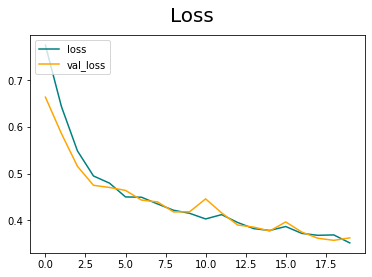

In [16]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

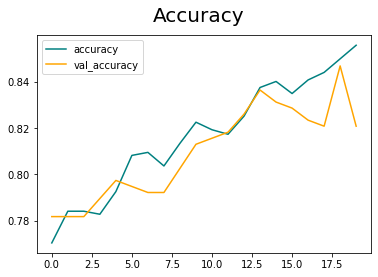

In [17]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 4. Test some examples

In [18]:
def review_model_predictions(data = data, START_FRAME = 200, END_FRAME = 300 ):
    no_of_frames = END_FRAME - START_FRAME
    # import math
    nrows = math.ceil(no_of_frames/5)
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(22, nrows * 2.5))

    # Flattening the axs array to iterate through it
    axs = axs.flatten()

    # iterate through data to create histograms
    for i, j in zip(range(START_FRAME,END_FRAME ), range(no_of_frames)):
        # get the image by location (as json format)
        img_as_json = data['images'][i]

        # convert the json to nested list
        img_as_list = json.loads(img_as_json)

        # convert the json to np.array
        img_as_list = json.loads(img_as_json)
        img_as_array = np.array(img_as_list)

        # get model prediction and convert it to txt
        model_prediction = model.predict(np.expand_dims(img_as_array/255, 0))
        model_prediction = lookup.loc[np.argmax(model_prediction), 'motion']

        # convert the nested list to np.array
        img = np.array(img_as_list)
        axs[j].imshow(img, cmap='gray')
        axs[j].set_title(f"{data['motion'][i]} , {data['LMR'][i]}, Model: {model_prediction} ") # ,  {data['time-sec'][i]}

        # Hiding empty subplots if any
        for k in range(no_of_frames, len(axs)):
            axs[k].axis('off')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 31ms/step


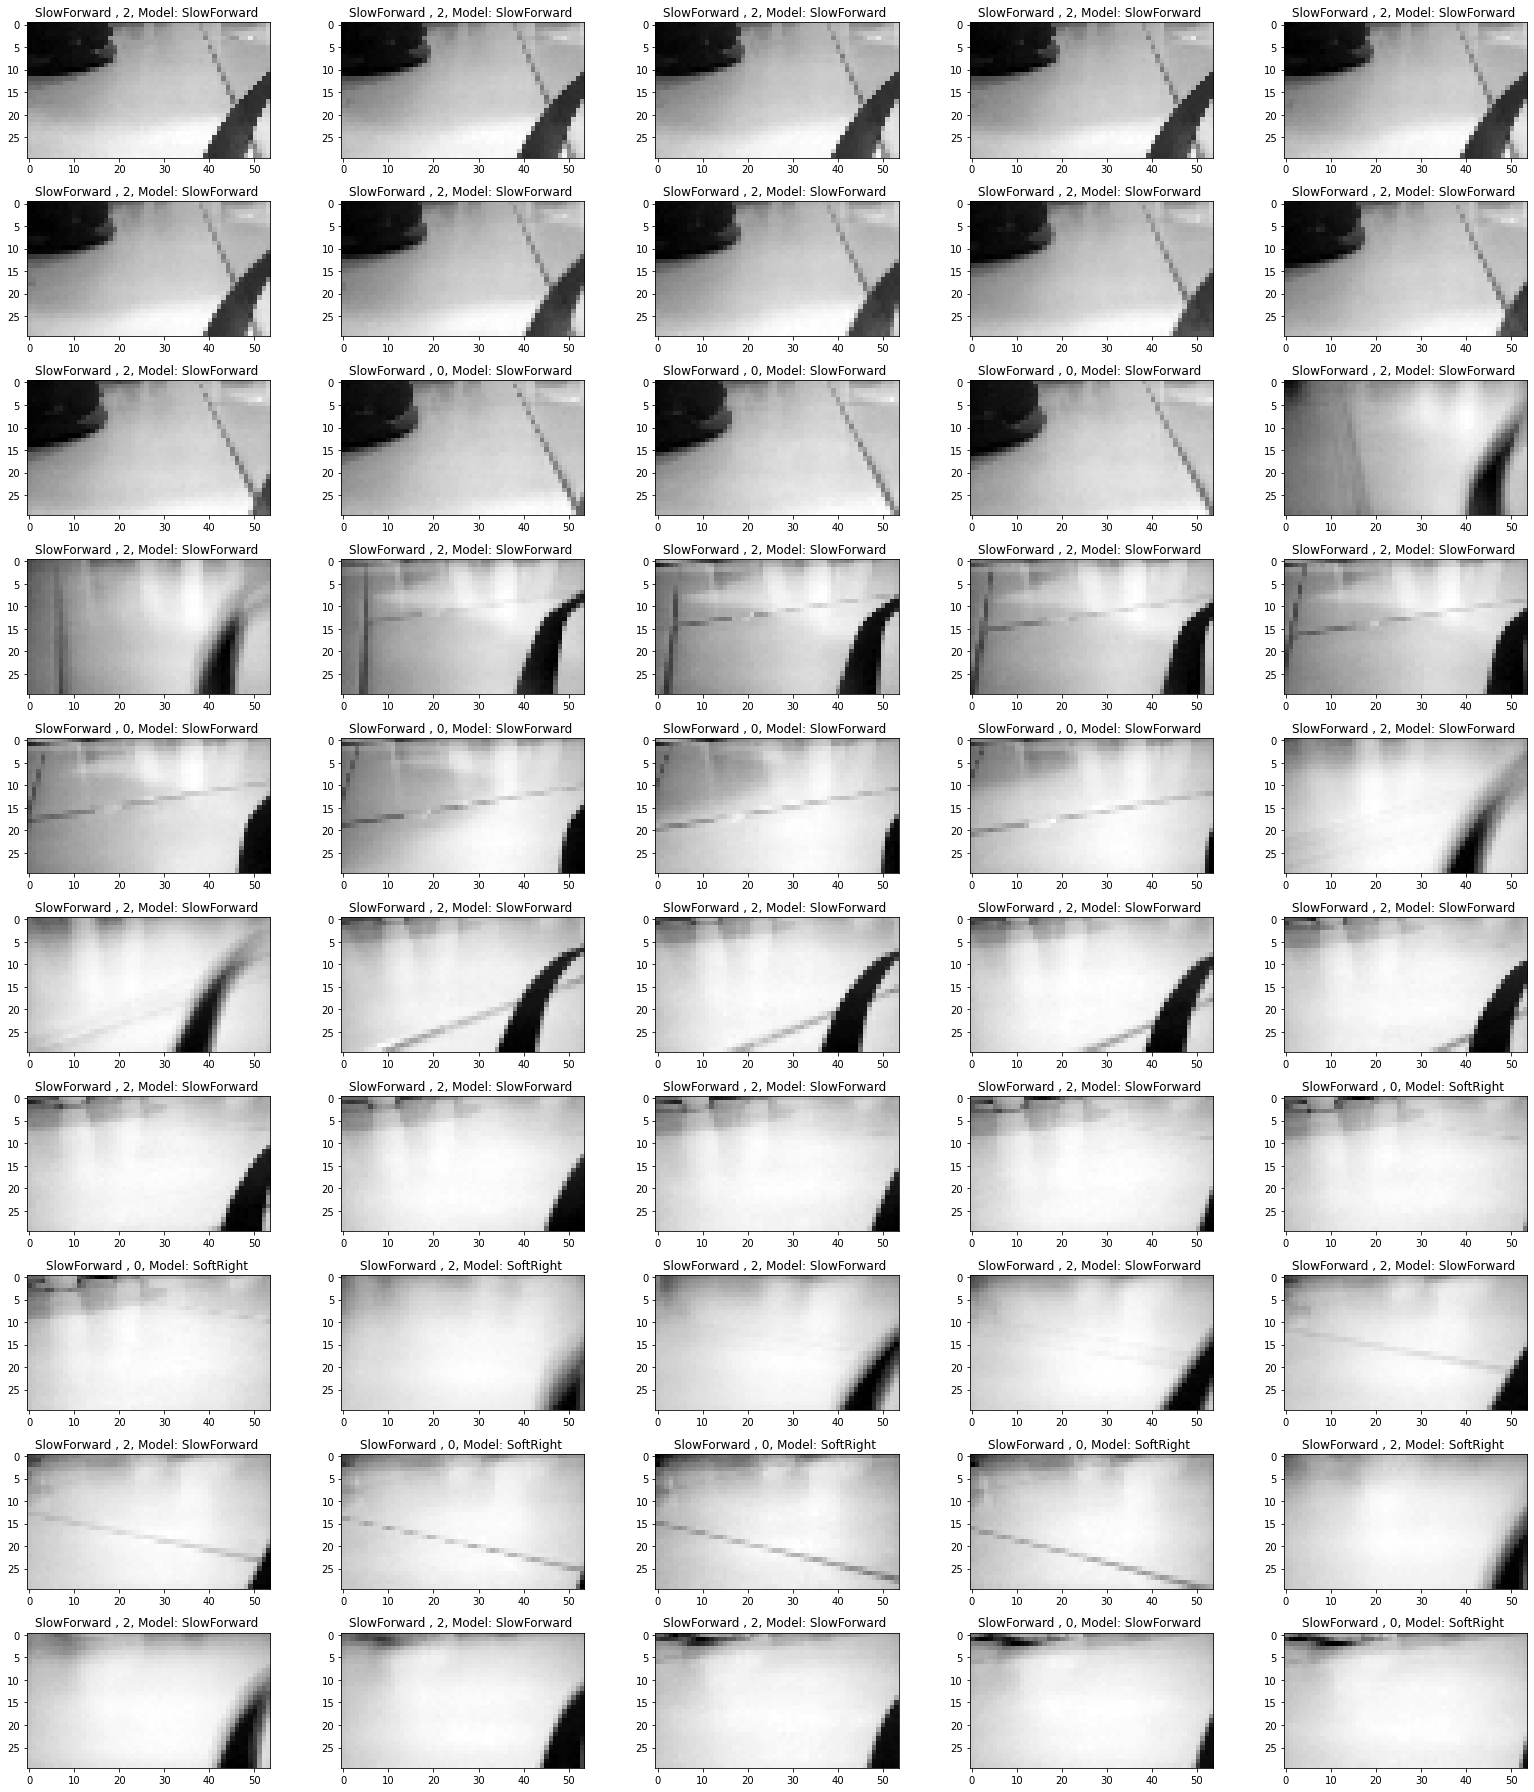

In [19]:
review_model_predictions(data = data, 
                         START_FRAME = 0, 
                         END_FRAME = 50 )

## 5. Save the model

In [20]:
model.save('computer_vision_driver.h5')

## 6. Create & Evaluate TensorFlow Lite model
https://colab.research.google.com/drive/1MTMWpavykGkzG_5TeRW4lKKdocNBj9To

In [3]:
from tensorflow.keras.models import load_model

# load TF model
new_model = load_model('computer_vision_driver.h5')

In [4]:
# Convert the Keras model to tflite model
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\peter\AppData\Local\Temp\tmpkbof7h9c\assets


INFO:tensorflow:Assets written to: C:\Users\peter\AppData\Local\Temp\tmpkbof7h9c\assets


In [5]:
# name and save the model to
tflite_model_name = "computer_vision_driver.tflite"
open(tflite_model_name, "wb").write(tflite_model)

126296

In [7]:
# Check input Tensor shape

interpreter = tf.lite.Interpreter(model_path = tflite_model_name)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 30 54  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


## 7. Load and use TFLite model

In [ ]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path = 'computer_vision_driver.tflite')
interpreter.allocate_tensors()

In [ ]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Prepare input data
input_shape = input_details[0]['shape']
input_data =  test_image # Replace ... with your input data

In [ ]:
# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
# Model Prediction
np.argmax(output_data)